## Let's create a dataset by downloading images from Bing

In [17]:
%pip install bing-image-downloader==1.0.4

from bing_image_downloader import downloader

Note: you may need to restart the kernel to use updated packages.


In [18]:
QUERIES = ["Mésange noire", "Mésange charbonnière", "Moineau"]
OUTPUT_DIR = 'dataset_images'
NB_IMAGES = 50

for query in QUERIES:
    downloader.download(
        query, NB_IMAGES, OUTPUT_DIR,
        adult_filter_off=False, force_replace=False, timeout=15
    )



[!!]Indexing page: 1

[%] Indexed 50 Images on Page 1.


[%] Downloading Image #1 from https://oiseau-mesange.fr/wp-content/uploads/2013/01/Mésange-noire-02.jpg
[!] Issue getting: https://oiseau-mesange.fr/wp-content/uploads/2013/01/Mésange-noire-02.jpg
[!] Error:: 'ascii' codec can't encode character '\xe9' in position 33: ordinal not in range(128)
[%] Downloading Image #1 from https://passion-nature.net/wp-content/uploads/2018/02/mesange-noire.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://img.fotocommunity.com/mesange-noire-17a8f1f0-8d02-418c-b8d4-d9586a8cba55.jpg?width=1000
[%] File Downloaded !

[%] Downloading Image #3 from https://img.fotocommunity.com/mesange-noire-fb51f603-a966-477a-8c3e-2a4470f3933a.jpg?height=1080
[%] File Downloaded !

[%] Downloading Image #4 from http://www.photo-vendee.com/image/photo-oiseaux/2707-mesange-noire-8419.jpg
[%] File Downloaded !

[%] Downloading Image #5 from http://oiseau-mesange.fr/wp-content/uploads/2013/01/Mésange-noi

KeyboardInterrupt: 

### Generate a dataframe from the downloaded images

In [41]:
import os
import pandas as pd
from glob import glob

QUERIES = ['IEC-320','VGA']
OUTPUT_DIR = 'Connecteurs'

for query in QUERIES:
    downloader.download(
        query, NB_IMAGES, OUTPUT_DIR,
        adult_filter_off=False, force_replace=False, timeout=15
    )

data = []

for label_dir in os.listdir(OUTPUT_DIR):
    if os.path.isfile(label_dir):
        continue
    
    label_path_path = os.path.join(OUTPUT_DIR, label_dir)
    for file in os.listdir(label_path_path):
        data.append([os.path.join(label_path_path, file), label_dir])
        
dataframe = pd.DataFrame(data, columns = ["path", "label"])
dataframe



[!!]Indexing page: 1

[%] Indexed 50 Images on Page 1.


[%] Downloading Image #1 from https://www.bestmarkt.hu/img/main-16x9/458734-62k71.jpg
[!] Issue getting: https://www.bestmarkt.hu/img/main-16x9/458734-62k71.jpg
[!] Error:: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1123)>
[%] Downloading Image #1 from https://www.oehling.cz/data/imgs/01/0078001l.jpg
[!] Issue getting: https://www.oehling.cz/data/imgs/01/0078001l.jpg
[!] Error:: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1123)>
[%] Downloading Image #1 from https://images.inetbote.de/new/artikel/11806B.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://www.oehling.cz/data/imgs/09/0078009l.jpg
[!] Issue getting: https://www.oehling.cz/data/imgs/09/0078009l.jpg
[!] Error:: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1123)>
[%] D

[%] File Downloaded !

[%] Downloading Image #16 from http://plugrand.com/Uploads/5b9b701386e8c6613.jpg
[%] File Downloaded !

[%] Downloading Image #17 from https://i.ebayimg.com/images/g/8asAAOSw-1NfcnId/s-l400.jpg
[%] File Downloaded !

[%] Downloading Image #18 from http://www.eonviccables.com/photo/pl26406143-eonvic_iec_320_c14_male_to_4xc13_female_y_type_splitter_power_cord_1_8m.jpg
[%] File Downloaded !

[%] Downloading Image #19 from https://startreksecurity.com/wp-content/uploads/2019/11/Cable-IEC-320-C.jpg
[%] File Downloaded !

[%] Downloading Image #20 from https://www.planetaelectronico.com/images/productos/conector-iec-320-c14-chasis-1-7993.jpeg
[!] Issue getting: https://www.planetaelectronico.com/images/productos/conector-iec-320-c14-chasis-1-7993.jpeg
[!] Error:: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1123)>
[%] Downloading Image #20 from https://www.eurosellonline.de/media/image/product/92800/lg/netza

[%] File Downloaded !

[%] Downloading Image #35 from https://cdn.nedis.com/images/products_high_res/PCGP11950B_P20.JPG
[!] Issue getting: https://cdn.nedis.com/images/products_high_res/PCGP11950B_P20.JPG
[!] Error:: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1123)>
[%] Downloading Image #35 from https://talentec.es/wp-content/uploads/2018/06/Conector-IEC-320-C13-2-min.jpg
[!] Issue getting: https://talentec.es/wp-content/uploads/2018/06/Conector-IEC-320-C13-2-min.jpg
[!] Error:: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1123)>
[%] Downloading Image #35 from http://plugrand.com/Uploads/5ba1ce8c3e7cf4351.jpg
[%] File Downloaded !

[%] Downloading Image #36 from https://www.planetaelectronico.com/images/productos/conector-iec-320-c14-aereo-acodada-1-7991.jpeg
[!] Issue getting: https://www.planetaelectronico.com/images/productos/conector-iec-320-c14-aereo-acoda

[!] Issue getting: https://cdn.sandberg.site/products/images/lg/503-74_lg.jpg
[!] Error:: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1123)>
[%] Downloading Image #3 from https://images.tcdn.com.br/img/img_prod/703952/cabo_vga_com_duplo_filtro_1_5m_669_3_20191028210259.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://assets.aten.com/product/image/2l-2515.cables.vga-cables.45.jpg
[%] File Downloaded !

[%] Downloading Image #5 from http://www.venuscomputers.pk/wp-content/uploads/2014/11/VGA-CABLE-15M-15M-LCD-5M.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://jcpchub.com/wp-content/uploads/2020/09/VGA-Cable-jcpchub.com_.png
[%] File Downloaded !

[%] Downloading Image #7 from https://mackabler.dk/13826-thickbox_default/vga-kabel.jpg
[%] File Downloaded !

[%] Downloading Image #8 from https://www.deleycon.de/wp-content/uploads/2013/09/2163_01.jpg
[!] Issue getting: https://www.deleycon.de/wp-c

[%] File Downloaded !



[!!]Indexing page: 2

[%] Indexed 35 Images on Page 2.


[%] Downloading Image #40 from https://http2.mlstatic.com/cable-vga-a-vga-10-metros-conectores-macho-macho-pc-y-laptop-D_NQ_NP_800109-MLM31240131460_062019-F.jpg
[%] File Downloaded !

[%] Downloading Image #41 from https://sig-shop.tn/wp-content/uploads/2020/10/cable-VGA-1.5m.jpg
[!] Issue getting: https://sig-shop.tn/wp-content/uploads/2020/10/cable-VGA-1.5m.jpg
[!] Error:: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1123)>
[%] Downloading Image #41 from https://http2.mlstatic.com/cable-vga-a-vga-10-metros-conectores-macho-macho-pc-y-laptop-D_NQ_NP_16525-MLM20121602458_072014-F.jpg
[%] File Downloaded !

[%] Downloading Image #42 from https://cdn.sandberg.site/products/images/lg/503-74_lg.jpg
[!] Issue getting: https://cdn.sandberg.site/products/images/lg/503-74_lg.jpg
[!] Error:: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate v

,path,label
0,Connecteurs\HDMI\Image_1.jpg,HDMI
1,Connecteurs\HDMI\Image_10.jpg,HDMI
2,Connecteurs\HDMI\Image_11.jpeg,HDMI
3,Connecteurs\HDMI\Image_12.jpg,HDMI
4,Connecteurs\HDMI\Image_13.jpg,HDMI
...,...,...
195,Connecteurs\VGA\Image_50.jpg,VGA
196,Connecteurs\VGA\Image_6.png,VGA
197,Connecteurs\VGA\Image_7.jpg,VGA
198,Connecteurs\VGA\Image_8.jpg,VGA


### Show some images of the dataset

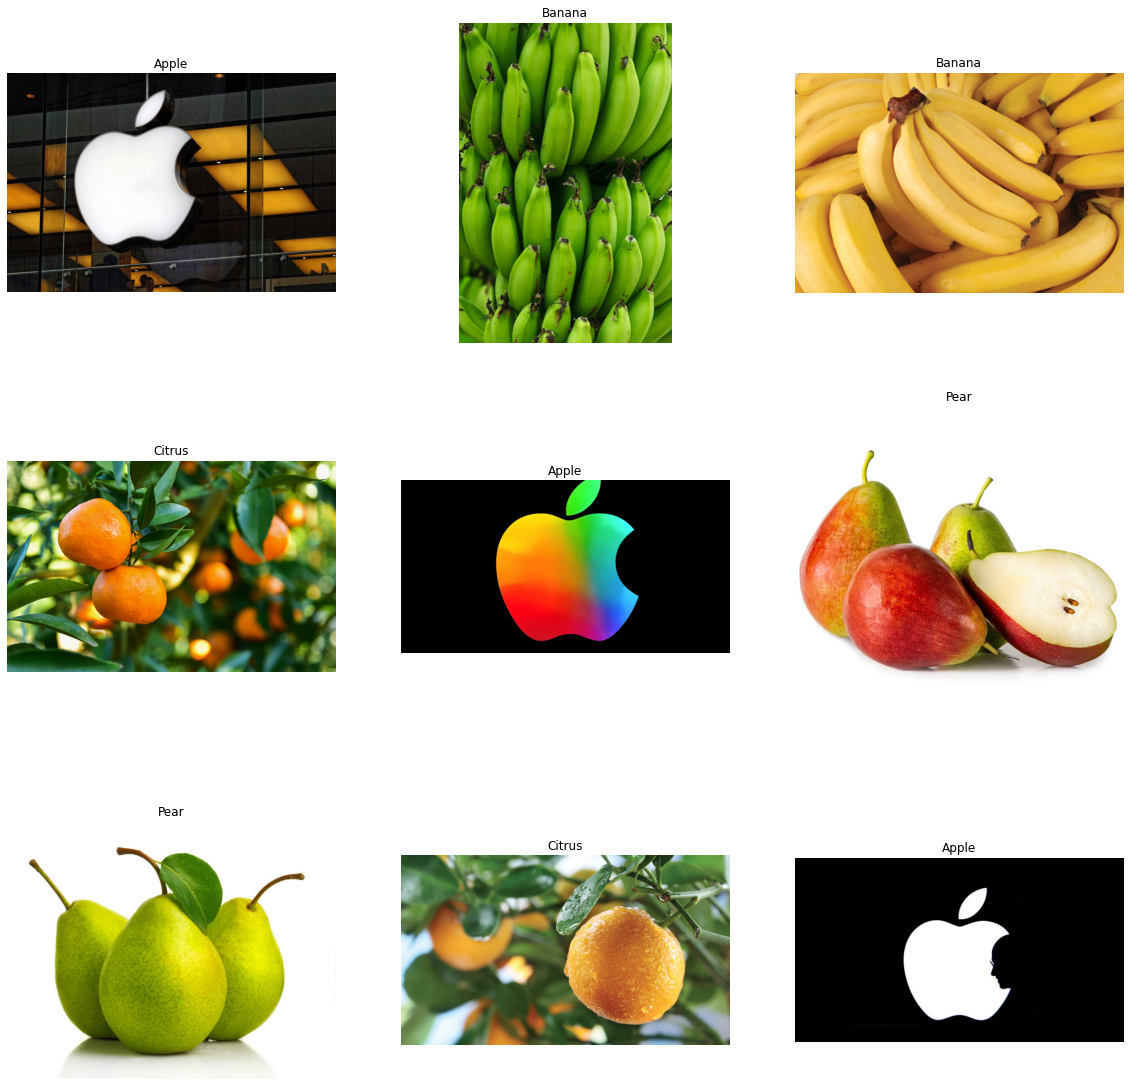

In [32]:
import matplotlib.pyplot as plt
import PIL
import PIL.Image
 
plt.figure(figsize=(20, 20))

i = 0
for _, rowdata in dataframe.sample(frac=1).head(9).iterrows():
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(PIL.Image.open(rowdata.path))
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1

## Fetch MobileNetV2 model

In [33]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False # We don't want to include the fully-connected layers
)

In [34]:
# You can see the list of layers of this model
base_model.layers

In [35]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Flatten,
    Dense,
    Dropout
)

def get_model():
    # We want to add layers on top of the base (here MobileNetV2) model
    layers = base_model.output

    # We need to flatten
    layers = Flatten()(layers)

    # TODO: add some dense layers here
    layers = Dense(50, activation='relu')(layers)
    layers = Dropout(0.5)(layers)

    # We must add an output layer
    output = Dense(len(QUERIES), activation='softmax')(layers) # final layer with softmax activation

    model = Model(inputs=base_model.input, outputs=output)

    # TODO: freeze the base model layers (not the layers you've added obviously)
    # NOTE:
    # to feeze a layer you can set its trainable flag to False (e.g. layer.trainable = False)
    # to get a list of the model layers you can do model.layers
    for layer in model.layers[:len(base_model.layers)]:
      layer.trainable=False

    model.compile(
      optimizer = RMSprop(),
      # Sparse categorical crossentropy is used when we have target class as integers
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )
        
    return model

In [36]:
get_model().summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

## Cross validate model

In [37]:
from tensorflow.keras.layers import Resizing, Rescaling
from tensorflow.keras import Sequential

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

In [38]:
def open_images(paths):
    images = []
    for path in paths:
        with PIL.Image.open(path) as image:
            images.append(image_preprocesses(np.asarray(image)))
            
    return np.array(images)

In [39]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

shuffled_dataset = dataframe.sample(frac=1, random_state=1234).reset_index(drop=True)

dataset_paths = shuffled_dataset['path'].to_numpy()
dataset_labels = shuffled_dataset['label'].to_numpy()

total_train_paths, test_paths, total_train_labels, test_labels = train_test_split(
    dataset_paths, dataset_labels, test_size=0.2, random_state=1234
)

# We need to convert from string labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(dataset_labels)
total_train_labels = label_encoder.transform(total_train_labels)
test_labels = label_encoder.transform(test_labels)

NB_EPOCHS = 4

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for train_index, val_index in KFold(n_splits=5).split(total_train_paths, total_train_labels):
    train_images = open_images(total_train_paths[train_index])    
    train_labels = total_train_labels[train_index]
    
    val_images = open_images(total_train_paths[val_index])
    val_labels = total_train_labels[val_index]
    
    model = get_model() # We reinitialize the model
    
    history = model.fit(
        x=train_images,
        y=train_labels,
        batch_size=32,
        validation_data=[val_images, val_labels],
        epochs=NB_EPOCHS,
    )
    
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])

ValueError: Exception encountered when calling layer "resizing_2" (type Resizing).

Expected an image array with shape `(height, width, channels)`, or `(batch_size, height, width, channels)`, but got input with incorrect rank, of shape (1280, 1280).

Call arguments received:
  • inputs=tf.Tensor(shape=(1280, 1280), dtype=uint8)

In [ ]:
def plot_kfold_mean_performance(ax, train_performances, val_performances, measure_name):
    train_mean = np.mean(train_performances, axis=0)
    val_mean = np.mean(val_performances, axis=0)
    train_sd = np.std(train_performances, axis=0)
    val_sd = np.std(val_performances, axis=0)
    
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean+train_sd, facecolor='blue', alpha=0.5, label='Train')
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean-train_sd, facecolor='blue', alpha=0.5)

    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean+val_sd, facecolor='orange', alpha=0.5, label='Val')
    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean-val_sd, facecolor='orange', alpha=0.5)

    ax.set_xticks(np.arange(NB_EPOCHS))

    ax.set_ylabel(measure_name)
    ax.set_xlabel('Number of epochs')
    #pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    ax.legend()
    ax.grid()


In [ ]:
import matplotlib.pyplot as pl

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12,6))

plot_kfold_mean_performance(axs[0], train_losses, val_losses, "Loss")
plot_kfold_mean_performance(axs[1], train_accuracies, val_accuracies, "Accuracy")

## Evaluate model on test set

In [ ]:
# First retrain model on all the training data
train_images = open_images(total_train_paths)    
train_labels = total_train_labels

model = get_model() # We reinitialize the model

history = model.fit(
    x=train_images,
    y=train_labels,
    batch_size=32,
    epochs=NB_EPOCHS,
)

In [ ]:
# Empty a bit the memory
import gc

del train_images
del train_labels
gc.collect()

In [ ]:
import sklearn.metrics as me

test_images = open_images(test_paths)    

pred = model.predict(test_images)
pred = np.argmax(pred, axis=-1)

test_confusion_matrix = me.confusion_matrix(test_labels, pred, labels=np.arange(len(QUERIES)))

In [ ]:
confusion_matrix_display = me.ConfusionMatrixDisplay(
    confusion_matrix=test_confusion_matrix,
    display_labels=QUERIES,
)

confusion_matrix_display.plot(xticks_rotation='vertical')
plt.show()